<h2>Анализ стоимости квартир в Минске</h2>
<h3>Цель</h3>
<h5>провести анализ стоимости 1-3-комнатных квартир г.Минска в зависимости от удаленности от метро, района города для молодой семьи.

In [1]:
import pandas as pd 
import numpy as np
import re

import csv
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

DATE = datetime.date.today()
FILE = f'agregate_apartment_{DATE}.csv'
DF = f'apartment_{DATE}.csv'

In [2]:
pd.set_option('display.max_rows', 100)
pach = '/Users/olgapalchul/doc/'
df = pd.read_csv(pach + 'apartment_2022-02-05.csv', sep = ';')

Выполним необходимые преобразования данных

In [3]:
df = df.drop_duplicates()
df.duplicated().sum()
df[df.isnull().any(axis = 1)]
#заменим пропуски в столбце metro_near "нет рядом" - так если не указано метро в объявлении - его нет рядом
df['metro_near'] = df['metro_near'].replace(np.nan, 'Нет рядом')
#уберем те квартиры, где нет цены и где продается комната
df = df.drop(df.loc[df['price_byn'] == 'Цена договорная'].index, inplace=False)
df = df.drop(df.loc[df['rooms'] == 'комната(доля)'].index, inplace=False)

In [4]:
# переведем цены в нужный формат
# цены на квартиры есть свыше млн - их необходимо также привести в нужный формат
df['price_byn'].replace(regex=True, inplace=True, to_replace=r'[a-zA-Z а-яА-ЯёЁ]', value=r'')
df['price_byn'] = df['price_byn'].map(lambda x: str(x))
df['price_byn'] = df['price_byn'].map(lambda x: str(x).replace(',', '.'))
df['price_byn'] = df['price_byn'].map(lambda x: float(x))
df['price_byn'] = df['price_byn'].map(lambda x: x * 1000000 if x < 10 else x)
df['metro'] = df['metro_near'].map(lambda x: 'no' if x=='Нет рядом' else 'yes')
# введем столбец цены в долларах
df['price_dol'] = (df['price_byn'] / 2.6).round()

In [5]:
#приведем к нужному формату количество комнат и дату
df['rooms'] = df['rooms'].map(lambda x: int(x))
df['date'] = pd.to_datetime(df['date'])

In [6]:
#выделим в отдельный столбец название улицы, без дома

def split_adress(row):
    split = row['adress']
    adress_split = re.split(',', split)
    return adress_split[0]

df['street'] = df.apply(split_adress, axis=1)

In [7]:
df.head(10)

,adress,district,metro_near,rooms,price_byn,date,metro,price_dol,street
0,"Маркса ул., 42",Ленинский,Октябрьская,4,1280000.0,2022-02-02,yes,492308.0,Маркса ул.
1,"Туровского ул., 8",Первомайский,Восток,4,440924.0,2022-02-02,yes,169586.0,Туровского ул.
2,Тимирязева ул.,Центральный,Нет рядом,2,340075.0,2021-10-12,no,130798.0,Тимирязева ул.
3,"Академическая ул., 17",Первомайский,Академия наук,3,752608.0,2021-12-29,yes,289465.0,Академическая ул.
4,"Азгура ул., 1",Партизанский,Площадь Победы,6,687728.0,2022-01-26,yes,264511.0,Азгура ул.
5,"Друйская ул., 61",Советский,Нет рядом,1,487015.0,2022-01-20,no,187313.0,Друйская ул.
6,"Ратомская ул., 52",Центральный,Нет рядом,3,584958.0,2022-01-20,no,224984.0,Ратомская ул.
7,"Рокоссовского просп., 145",Ленинский,Нет рядом,2,186854.0,2022-01-28,no,71867.0,Рокоссовского просп.
8,"Мавра ул., 50",Фрунзенский,Спортивная,2,142736.0,2022-03-02,yes,54898.0,Мавра ул.
9,"Друйская ул., 61",Советский,Нет рядом,3,487015.0,2022-01-14,no,187313.0,Друйская ул.


In [8]:
df.head()
df.describe()

,rooms,price_byn,price_dol
count,13319.000000,1.331900e+04,1.331900e+04
mean,2.260155,2.170161e+05,8.346774e+04
std,1.003881,2.068906e+05,7.957331e+04
min,1.000000,4.282100e+04,1.647000e+04
25%,1.000000,1.310580e+05,5.040700e+04
50%,2.000000,1.783420e+05,6.859300e+04
75%,3.000000,2.307470e+05,8.874900e+04
max,10.000000,5.060000e+06,1.946154e+06


<h5>Проанализируем стоимость квартир в разрезе районов

In [12]:
df1 = df.query('rooms < 4')

gr_district = df1.groupby('district', as_index=False)\
    .agg({'adress': 'count',\
    'price_dol': 'median',\
    })\
    .sort_values(by='adress', ascending=False)

gr_district.columns = ['район', 'количество квартир','медианная цена, дол']
gr_district['на дату'] = '2022-02-05'
gr_district

,район,количество квартир,"медианная цена, дол",на дату
10,Октябрьский,6350,53951.5,2022-02-05
15,Центральный,1296,98165.0,2022-02-05
9,Московский,1248,72457.5,2022-02-05
12,Первомайский,838,94825.0,2022-02-05
14,Фрунзенский,781,71867.0,2022-02-05
13,Советский,446,88836.0,2022-02-05
1,Заводской,365,55398.0,2022-02-05
2,Ленинский,353,73863.0,2022-02-05
11,Партизанский,210,68623.0,2022-02-05
8,"Минский р-н., Московское, 4 км. от МКАД",95,92828.0,2022-02-05


Да здравствует стройка Minsk World! - из-за крупной стройки в Октябрьском районе мы наблюдаем огромное количество продаваемых квартир, в том числе на этапе котлавана. За счет большого количества строящихся квартир Minsk World медианная цена будет сформирована этими квартирами. 

Уберем квартиры, расположенные за МКАД - они не интересуют молодую семью. В идеале, квартира должна располагаться недалеко от метро (10-15 минут), на синей линии или в центре города (в таком случае это захватывает станции красной ветки - Немигу, Купаловскую и Пролетарскую). 

In [13]:
#save fail
gr_district.to_csv(r'/Users/olgapalchul/doc/gr_district_2022_02_05.csv', sep=';', columns=['район', 'количество квартир', \
                                                        'медианная цена, дол', 'на дату'])

<h4>

<h5>Проанализируем стоимость 1-3-комнатных квартир в разрезе районов

In [14]:
districts = ['Октябрьский ', 'Центральный ', 'Московский ',\
           'Первомайский ','Фрунзенский ', 'Советский ',\
           'Ленинский ','Заводской ','Партизанский ']

df1 = df1.query("district in @districts")
df1.head()

,adress,district,metro_near,rooms,price_byn,date,metro,price_dol,street
2,Тимирязева ул.,Центральный,Нет рядом,2,340075.0,2021-10-12,no,130798.0,Тимирязева ул.
3,"Академическая ул., 17",Первомайский,Академия наук,3,752608.0,2021-12-29,yes,289465.0,Академическая ул.
5,"Друйская ул., 61",Советский,Нет рядом,1,487015.0,2022-01-20,no,187313.0,Друйская ул.
6,"Ратомская ул., 52",Центральный,Нет рядом,3,584958.0,2022-01-20,no,224984.0,Ратомская ул.
7,"Рокоссовского просп., 145",Ленинский,Нет рядом,2,186854.0,2022-01-28,no,71867.0,Рокоссовского просп.


In [15]:
df1.describe()

,rooms,price_byn,price_dol
count,11887.000000,1.188700e+04,1.188700e+04
mean,2.058467,1.929132e+05,7.419740e+04
std,0.821344,1.185064e+05,4.557939e+04
min,1.000000,4.282100e+04,1.647000e+04
25%,1.000000,1.255705e+05,4.829650e+04
50%,2.000000,1.684280e+05,6.478000e+04
75%,3.000000,2.201040e+05,8.465500e+04
max,3.000000,3.890000e+06,1.496154e+06


In [16]:
district_piv = df1.pivot_table(index='district',\
                             values='price_dol',\
                             columns='rooms',\
                             aggfunc='median',\
                             fill_value=0)\
                            .sort_values(by='district',ascending=False).rename_axis(None, axis=1)

district_piv['на дату'] = '2022-02-05'
district_piv

,1,2,3,на дату
district,,,,
Центральный,65684.0,88836.0,157090.0,2022-02-05
Фрунзенский,55897.0,71767.0,89734.0,2022-02-05
Советский,63882.0,84543.5,121675.0,2022-02-05
Первомайский,68873.0,84094.5,132755.0,2022-02-05
Партизанский,47862.0,62784.0,114788.0,2022-02-05
Октябрьский,35780.0,51405.0,71705.0,2022-02-05
Московский,57918.0,68417.0,89862.5,2022-02-05
Ленинский,52852.0,70819.0,88835.0,2022-02-05
Заводской,44168.5,54898.0,69422.0,2022-02-05


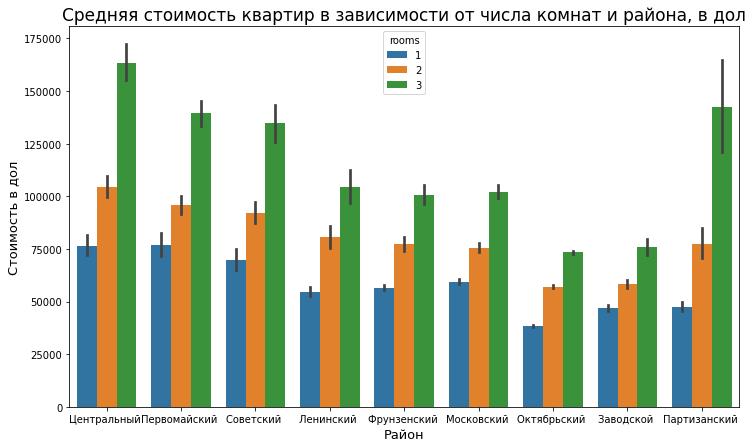

In [17]:
plt.figure(figsize=(12, 7))
sns.barplot(x='district', y='price_dol', data=df1, hue='rooms')
plt.title('Средняя стоимость квартир в зависимости от числа комнат и района, в дол', fontsize=17)
plt.ylabel('Стоимость в дол', fontsize=13)
plt.xlabel('Район', fontsize=13)
plt.show()

Самая невысокая стоимость 1-3-комнатных квартир - в Октябрьском районе, это обусловлено, как было сказано выше, стройкой целого квартала, многие из этих домов находятся на этапе котлавана/коробки, что снижает их конечную стоимость. Квартиры в Заводском и Партизанском районе (исключая 3-х комнатные квартиры Партизанского района - скорее всего, это влияние "сталинок", расположенных в центре и вдоль Партизанского проспекта), также самые недогорие по городу, что можно объяснить низким престижем квартир. Самая высокая стоимость жилья - в Центральном, Первомайском и Советском районах. 

In [ ]:
#save fail
district_piv.to_csv(r'/Users/olgapalchul/doc/district_piv_2022_02_05.csv', sep=';')

<h5>Проанализируем стоимость 1-3-комнатных квартир в разрезе станций метро

In [18]:
metro_piv = df1.pivot_table(index='metro_near',\
                             values='price_dol',\
                             columns='rooms',\
                             aggfunc='median',\
                             fill_value=0)\
                            .sort_values(by='metro_near',ascending=False).rename_axis(None, axis=1)
                            #.head(9)

metro_piv['на дату'] = '2022-02-05'                           

In [ ]:
#save fail
metro_piv.to_csv(r'/Users/olgapalchul/doc/metro_piv_2022_02_05.csv', sep=';')

Разделим все станции метро на условный центр города, и на синию, красную, зеленую линии, разделенные центром. Построим боксплоты стоимостей 1-3-комнатных квартир, уберем квартиры, расположенные за 90-перцентилем - как самые дорогие и не выходящие за рамки бюджета

In [19]:
centre = ['Октябрьская', 'Площадь Победы', 'Площадь Якуба Коласа', 'Площадь Ленина', 'Институт культуры', 'Вокзальная', 'Купаловская', 'Немига', 'Первомайская']
blu1 = ['Михалово', 'Грушевка', 'Петровщина', 'Малиновка']
blu2 = ['Восток', 'Академия наук', 'Уручье', 'Московская', 'Парк Челюскинцев', 'Борисовский тракт']
red1 = ['Спортивная', 'Фрунзенская', 'Каменная горка', 'Пушкинская', 'Кунцевщина', 'Молодежная']
red2 = ['Партизанская', 'Пролетарская', 'Автозаводская', 'Могилевская', 'Тракторный завод']
green = ['Аэродромная (2023)', 'Ковальская Слобода', 'Неморшанский сад (2023)', 'Площадь Богушевича', 'Слуцкий гостинец (2023)', 'Юбилейная площадь']
no_metro = ['Нет рядом']


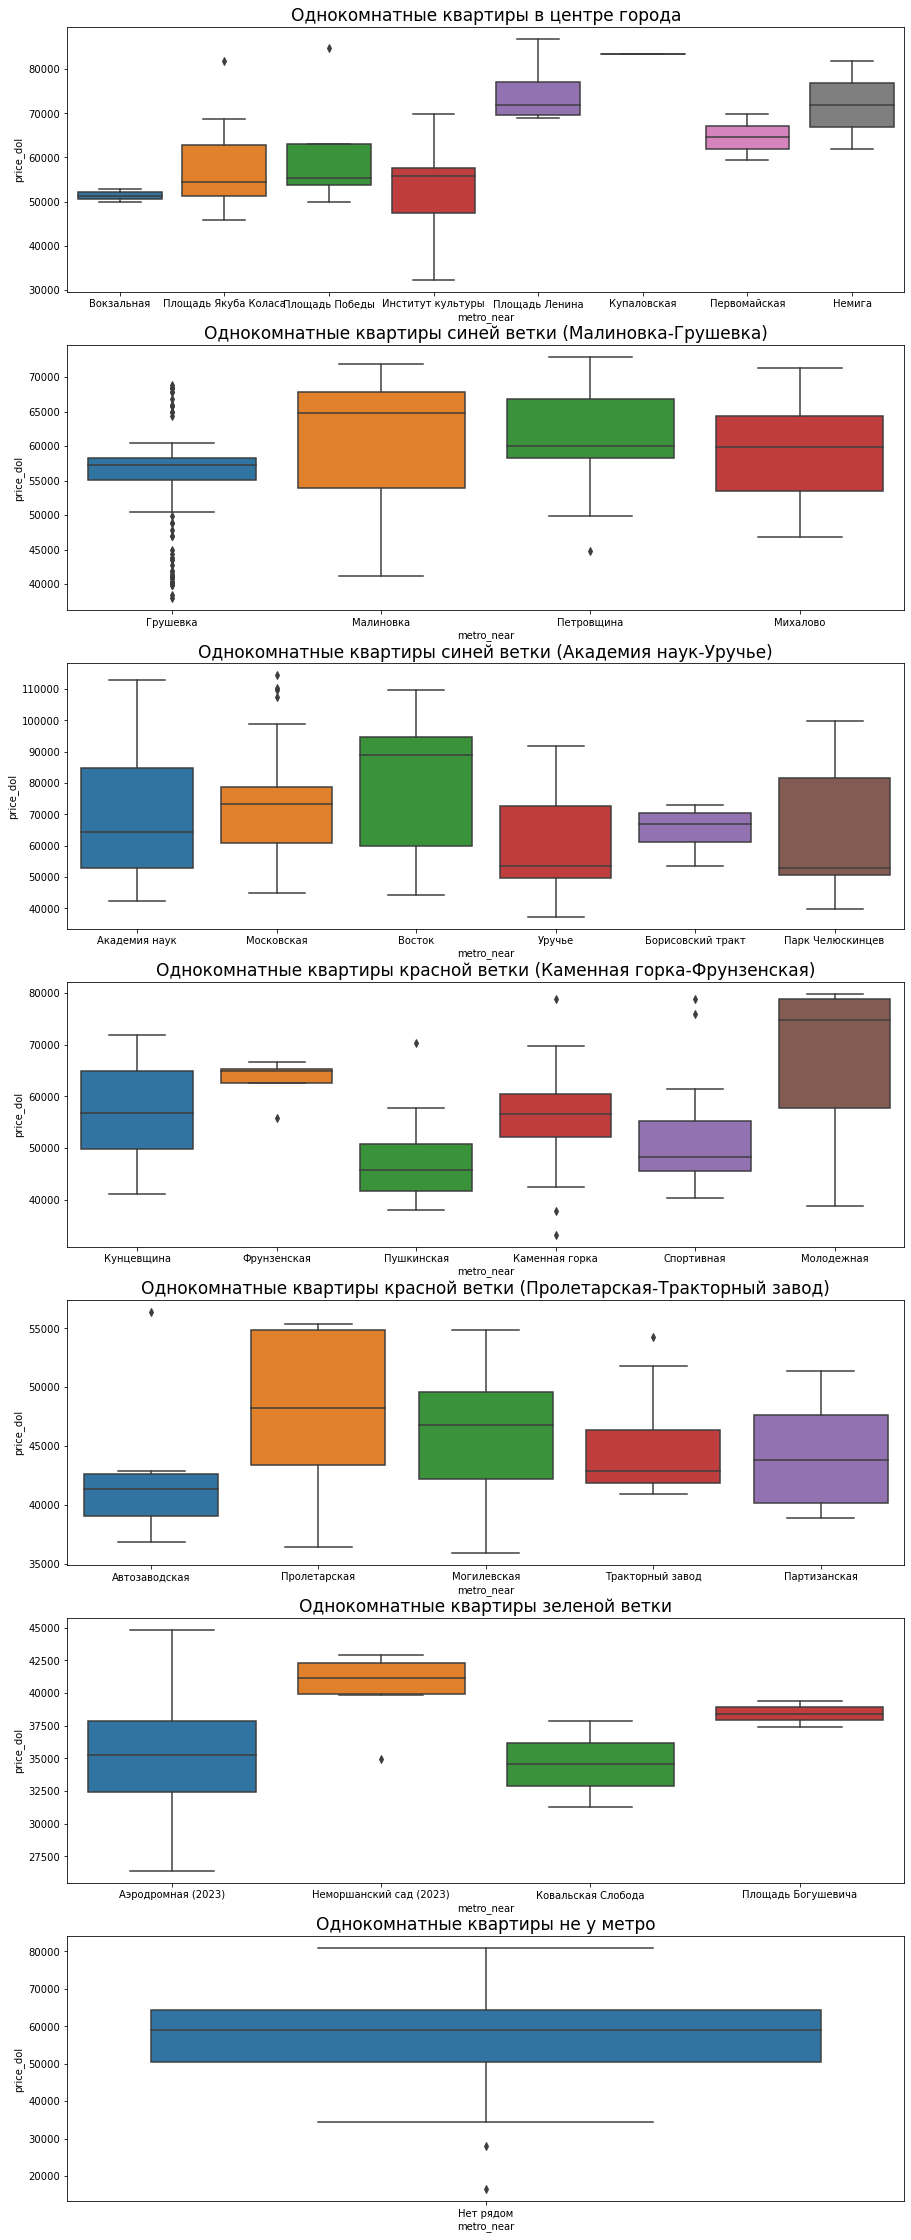

In [32]:
fig, ax = plt.subplots(nrows = 7, ncols = 1, figsize=(15,40))

data1 = df1.query("metro_near in @centre and rooms == 1")
ax[0].set_title('Однокомнатные квартиры в центре города',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[0])

data1 = df1.query("metro_near in @blu1 and rooms == 1")
ax[1].set_title('Однокомнатные квартиры синей ветки (Малиновка-Грушевка)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[1])

data1 = df1.query("metro_near in @blu2 and rooms == 1")
ax[2].set_title('Однокомнатные квартиры синей ветки (Академия наук-Уручье)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[2])

data1 = df1.query("metro_near in @red1 and rooms == 1")
ax[3].set_title('Однокомнатные квартиры красной ветки (Каменная горка-Фрунзенская)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol",
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[3])

data1 = df1.query("metro_near in @red2 and rooms == 1")
ax[4].set_title('Однокомнатные квартиры красной ветки (Пролетарская-Тракторный завод)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[4])

data1 = df1.query("metro_near in @green and rooms == 1")
ax[5].set_title('Однокомнатные квартиры зеленой ветки',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[5])

data1 = df1.query("metro_near in @no_metro and rooms == 1")
ax[6].set_title('Однокомнатные квартиры не у метро',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[6])
plt.show()

В целом, однокомнатные квартиры по Минску не сильно отличаются в цене – разброс стоимости от 40 до 60 тыс дол (цены недвижимости привязаны к доллару, который пересчитывается в рубли), за исключением самого центра – Площадь Ленина, Первомайская, Немига – стоимость квартиры возле этих станций метро дороже. Одни из самых недорогих квартир возле метро находятся возле недостроенной зеленой ветки метро. Отсутствие рядом с домом метро не гарантирует более низкую стоимость жилья.

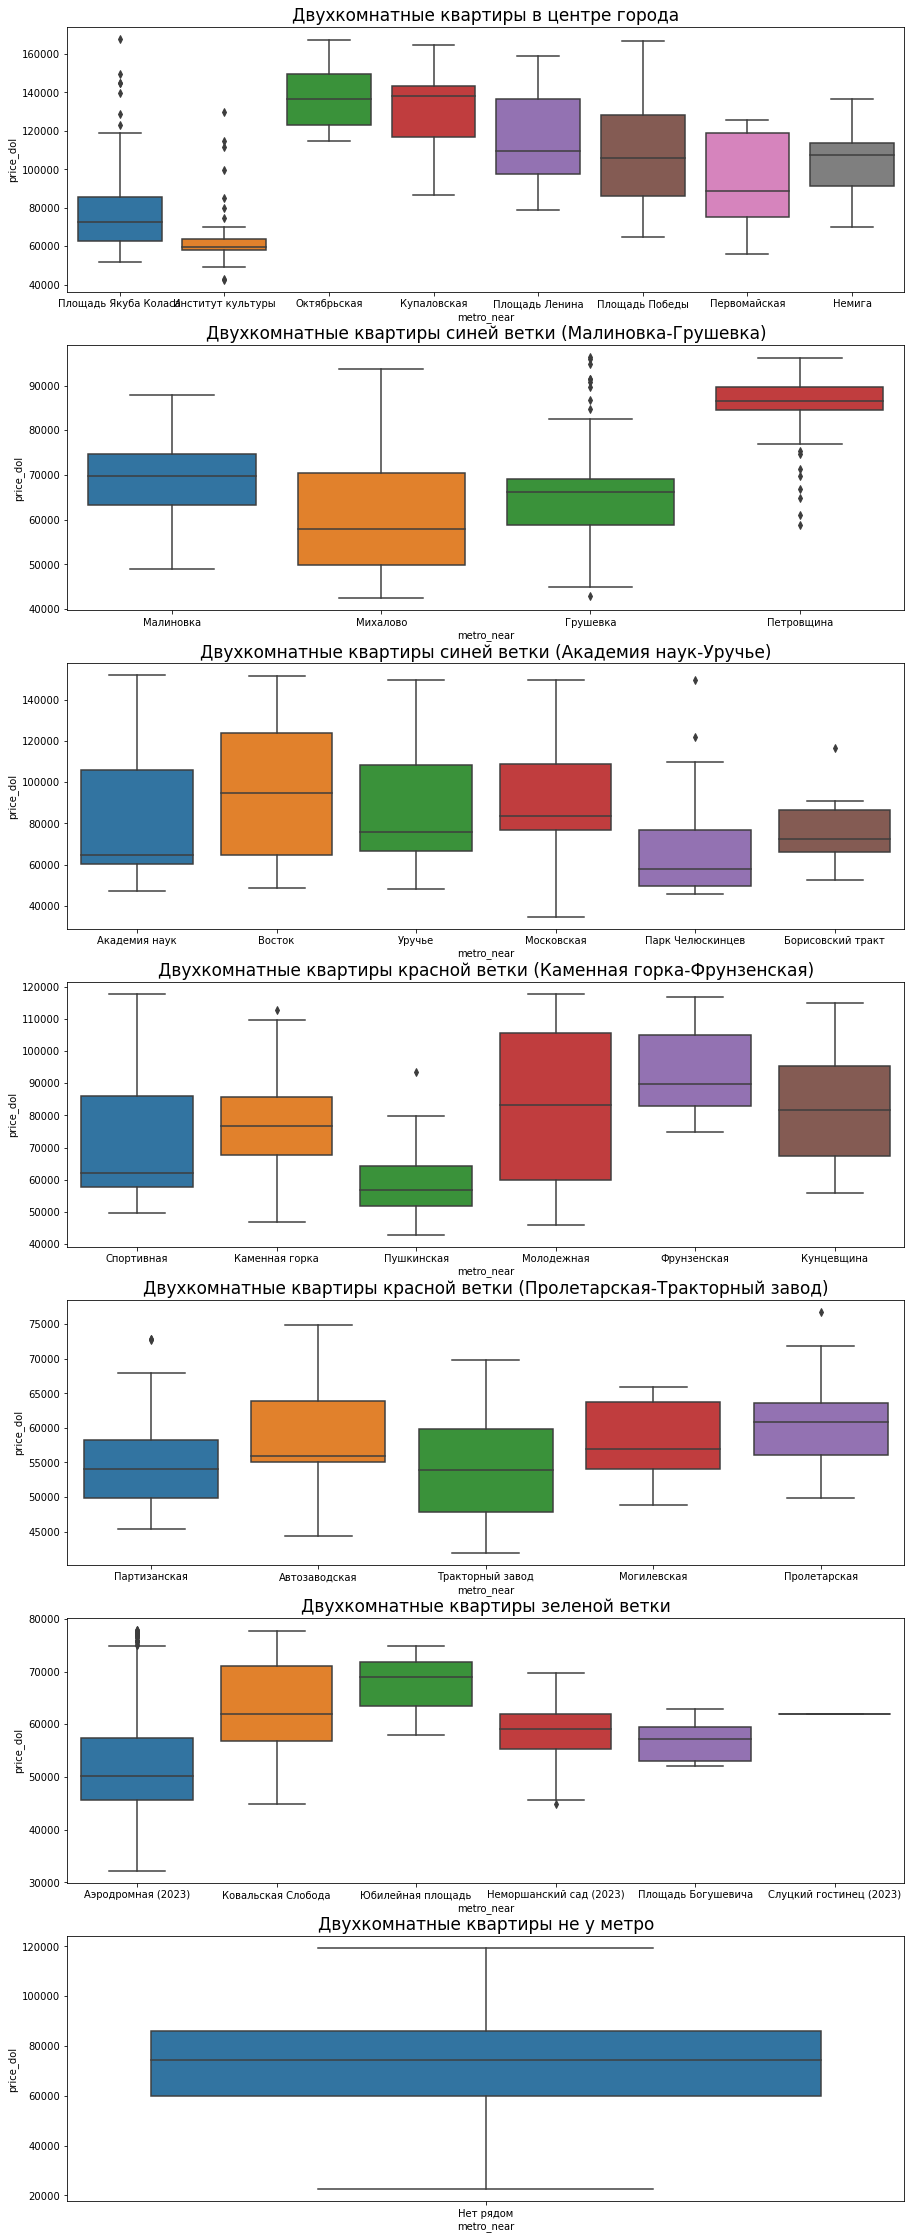

In [31]:
fig, ax = plt.subplots(nrows = 7, ncols = 1, figsize=(15,40))

data1 = df1.query("metro_near in @centre and rooms == 2")
ax[0].set_title('Двухкомнатные квартиры в центре города',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[0])
# fig.autofmt_xdate(rotation=25)

data1 = df1.query("metro_near in @blu1 and rooms == 2")
ax[1].set_title('Двухкомнатные квартиры синей ветки (Малиновка-Грушевка)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[1])

data1 = df1.query("metro_near in @blu2 and rooms == 2")
ax[2].set_title('Двухкомнатные квартиры синей ветки (Академия наук-Уручье)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[2])

data1 = df1.query("metro_near in @red1 and rooms == 2")
ax[3].set_title('Двухкомнатные квартиры красной ветки (Каменная горка-Фрунзенская)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol",
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[3])

data1 = df1.query("metro_near in @red2 and rooms == 2")
ax[4].set_title('Двухкомнатные квартиры красной ветки (Пролетарская-Тракторный завод)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[4])

data1 = df1.query("metro_near in @green and rooms == 2")
ax[5].set_title('Двухкомнатные квартиры зеленой ветки',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[5])

data1 = df1.query("metro_near in @no_metro and rooms == 2")
ax[6].set_title('Двухкомнатные квартиры не у метро',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[6])
plt.show()

На фоне 60 и более тыс за однушки, цены двушек выглядят привлекательно - 60-80 тыс дол. Двухкомнатные квартиры в центре заметно дороже – их медианная цена, в целом выше, однако на Институте культуры и Площади Якуба Колоса можно найти неплохие варианты. Квартиры, расположенные на синей ветке метро и красной ветке (Каменная горка-Фрунзенская) стоят больше, чем квартиры Пролетарская-Тракторный завод и квартиры зеленой ветки (Юбилейная площадь находится возле Фрунзенской). <br>
С учетом стоимости одно- и двухкомнатных квартир, молодой семье стоит обратить внимание на двухкомнатные квартиры на Институте культуры, Площади Якуба Коласа, а также рассмотреть квартиры на красной ветке Пролетарская-Тракторный завод, вполне может быть, что там можно найти неплохие варианты. 


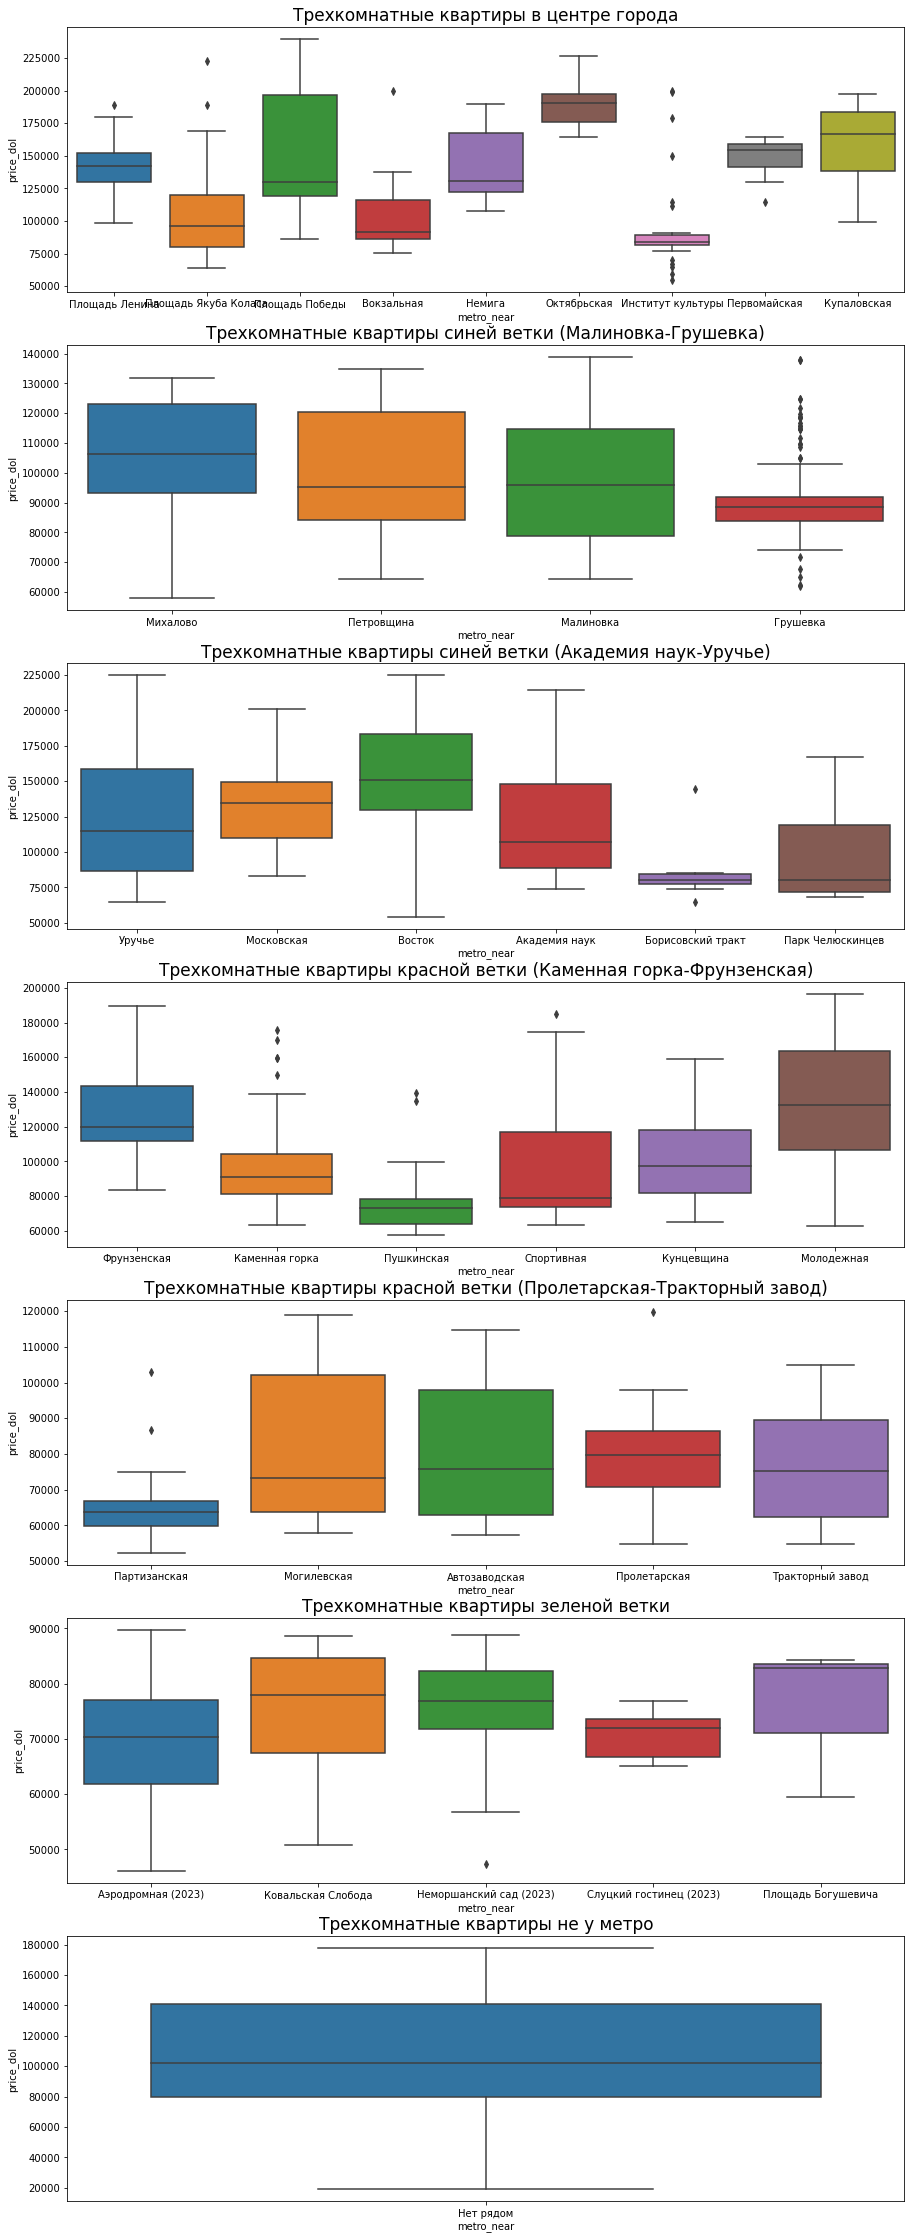

In [30]:
fig, ax = plt.subplots(nrows = 7, ncols = 1, figsize=(15,40))

data1 = df1.query("metro_near in @centre and rooms == 3")
ax[0].set_title('Трехкомнатные квартиры в центре города',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[0])
# fig.autofmt_xdate(rotation=25)

data1 = df1.query("metro_near in @blu1 and rooms == 3")
ax[1].set_title('Трехкомнатные квартиры синей ветки (Малиновка-Грушевка)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[1])

data1 = df1.query("metro_near in @blu2 and rooms == 3")
ax[2].set_title('Трехкомнатные квартиры синей ветки (Академия наук-Уручье)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[2])

data1 = df1.query("metro_near in @red1 and rooms == 3")
ax[3].set_title('Трехкомнатные квартиры красной ветки (Каменная горка-Фрунзенская)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol",
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[3])

data1 = df1.query("metro_near in @red2 and rooms == 3")
ax[4].set_title('Трехкомнатные квартиры красной ветки (Пролетарская-Тракторный завод)',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[4])

data1 = df1.query("metro_near in @green and rooms == 3")
ax[5].set_title('Трехкомнатные квартиры зеленой ветки',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[5])

data1 = df1.query("metro_near in @no_metro and rooms == 3")
ax[6].set_title('Трехкомнатные квартиры не у метро',fontsize=17)
sns.boxplot(x="metro_near", y="price_dol", 
                 data = data1[data1.price_dol < data1.price_dol.quantile(.90)], linewidth=1.5, ax = ax[6])
plt.show()

Трехкомнатные квартиры возле интересующих молодую семью станций метро стартуют от 90 и более тыс дол, что выходит за рамки их бюджета. 

<h3>Вывод</h3>
Молодой семье стоит рассмотреть вариант покупки 2-комнатной квартиры, которые, в среднем, стоят 60-80 тыс дол против 40-60 тыс дол за однакомнатную квартиру. Если рассматривать квартиры, расположенные в центре города, то стоит обратить внимание на Институт культуры и Площадь Якуба Колоса. Или же рассмотреть также квартиры, расположенные на красной ветке Пролетарская-Тракторный завод. 